In [1]:
import sys
sys.path.append("../../utils/")
import time
from tqdm.notebook import tqdm
import gc
import glob
import pickle
import torch
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold,GroupKFold
from sklearn.preprocessing import LabelEncoder

from loss import correl_loss
from trainer import Cite_Trainer

In [2]:
root_path = "../../../input/"
train = np.load("../../data_preprocessing/new_cite_train_final.npz")["arr_0"]
target = pd.read_hdf(f"{root_path}open-problems-multimodal/train_cite_targets.h5").values

print(train.shape,target.shape)

(70988, 735) (70988, 140)


In [10]:
config = dict(
    atte_dims = 128,
    output_num = target.shape[1],
    input_num = train.shape[1],
    dropout = 0.1,
    mlp_dims = [train.shape[1]*2,train.shape[1]],
    
    layers = 5,
    patience = 5,
    max_epochs = 100,
    criterion = correl_loss,
    batch_size = 128,

    n_folds = 3,
    folds_to_train = [0,1,2],
    kfold_random_state = 42,

    tb_dir = "./log/",

    optimizer = torch.optim.AdamW,
    optimizerparams = dict(lr=1e-4, weight_decay=1e-2,amsgrad= True),
    
    scheduler = torch.optim.lr_scheduler.MultiStepLR,

    schedulerparams = dict(milestones=[6,10,15,20,25,30], gamma=0.1,verbose  = True), #9,12,15,20,25,30
    min_epoch = 11,
)


In [4]:
train_index = np.load(f"{root_path}/multimodal-single-cell-as-sparse-matrix/train_cite_inputs_idxcol.npz",allow_pickle=True)
meta = pd.read_csv(f"{root_path}open-problems-multimodal/metadata.csv",index_col = "cell_id")
meta = meta[meta.technology=="citeseq"]
lbe = LabelEncoder()
meta["cell_type"] = lbe.fit_transform(meta["cell_type"])
meta["gender"] = meta.apply(lambda x:0 if x["donor"]==13176 else 1,axis =1)
meta_train = meta.reindex(train_index["index"])
train_meta = meta_train["gender"].values.reshape(-1, 1)
train = np.concatenate([train,train_meta],axis= -1)
train_meta = meta_train["cell_type"].values.reshape(-1, 1)
train = np.concatenate([train,train_meta],axis= -1)
train.shape

(70988, 737)

In [5]:
class conv_block(torch.nn.Module):
    def __init__(self,config):
        super().__init__()
        output_num = config["output_num"]
        self.input_num = config["input_num"]
        dropout = config["dropout"]
        mlp_dims = config["mlp_dims"]

        self.conv_2 = torch.nn.Sequential(
            torch.nn.Conv1d(
                in_channels = 512,
                out_channels = 512,
                kernel_size  = 3,
                stride  = 1,
                padding = 1,              
            ),
            torch.nn.Mish(),
            torch.nn.Conv1d(
                in_channels = 512,
                out_channels = 512,
                kernel_size  = 3,
                stride  = 1,
                padding = 1,              
            ),
            torch.nn.Mish(),
        )
        self.conv_2_1 = torch.nn.Sequential(
            torch.nn.Conv1d(
                in_channels = 512,
                out_channels = 512,
                kernel_size  = 5,
                stride  = 1,
                padding = 2,              
            ),
            torch.nn.Mish(),
            torch.nn.Conv1d(
                in_channels = 512,
                out_channels = 512,
                kernel_size  = 3,
                stride  = 1,
                padding = 1,              
            ),
            torch.nn.Mish(),
        )
        self.conv_2_2 = torch.nn.Sequential(
            torch.nn.Conv1d(
                in_channels = 512,
                out_channels = 512,
                kernel_size  = 15,
                stride  = 1,
                padding = 7,              
            ),
            torch.nn.Mish(),
            torch.nn.Conv1d(
                in_channels = 512,
                out_channels = 512,
                kernel_size  = 5,
                stride  = 1,
                padding = 2,              
            ),
            torch.nn.Mish(),
        )

    def forward(self,x):
        x1 = self.conv_2(x)
        x2 = self.conv_2_1(x)
        x3 = self.conv_2_2(x)
        x = x1+x2+x3+x
        return x 


In [6]:
class CNN(torch.nn.Module):
    def __init__(self,config):
        super().__init__()
        output_num = config["output_num"]
        self.input_num = config["input_num"]
        dropout = config["dropout"]
        mlp_dims = config["mlp_dims"]
        self.layers = config["layers"]

        self.backbone = torch.nn.Linear(self.input_num ,self.input_num)
        self.embedding_1 = torch.nn.Embedding(2,256)
        self.embedding_2 = torch.nn.Embedding(7,256)

        self.proj = torch.nn.Sequential(
            torch.nn.Linear(self.input_num,4096),
            # torch.nn.Linear(2048,4096)
        )
        self.conv_1 = torch.nn.Sequential(
            torch.nn.Conv1d(
                in_channels = 256,
                out_channels = 512,
                kernel_size  = 3,
                stride  = 1,
                padding = 1,              
            ),
            # torch.nn.Mish(),
            torch.nn.AvgPool1d(
                kernel_size=2,
            ),
            torch.nn.Conv1d(
                in_channels = 512,
                out_channels = 512,
                kernel_size  = 3,
                stride  = 1,
                padding = 1,              
            ),
            torch.nn.Mish(),
        )

        self.conv_1_1 = torch.nn.Sequential(
            torch.nn.Conv1d(
                in_channels = 256,
                out_channels = 512,
                kernel_size  = 5,
                stride  = 1,
                padding = 2,              
            ),
            # torch.nn.Mish(),

            torch.nn.AvgPool1d(
                kernel_size=2,
            ),
            torch.nn.Conv1d(
                in_channels = 512,
                out_channels = 512,
                kernel_size  = 3,
                stride  = 1,
                padding = 1,              
            ),
            torch.nn.Mish(),
        )

        self.conv_1_2 = torch.nn.Sequential(
            torch.nn.Conv1d(
                in_channels = 256,
                out_channels = 512,
                kernel_size  = 15,
                stride  = 1,
                padding = 7,              
            ),
            # torch.nn.Mish(),
            torch.nn.AvgPool1d(
                kernel_size=2,
            ),
            torch.nn.Conv1d(
                in_channels = 512,
                out_channels = 512,
                kernel_size  = 5,
                stride  = 1,
                padding = 2,              
            ),
            torch.nn.Mish(),
        )

        self.conv_layers = torch.nn.ModuleList()
        for i in range(self.layers):
            self.conv_layers.append(conv_block(config))

        self.final = torch.nn.Sequential(

            torch.nn.Flatten(),
            torch.nn.Linear(4096,2048),
            torch.nn.Mish(),
            torch.nn.Linear(2048,512),
            torch.nn.Mish(),
            torch.nn.Linear(512,output_num),
            torch.nn.Mish(),
            
        )
    
    def forward(self,x):
        x_ = self.embedding_2(x[:,-1].int())
        x_ = torch.repeat_interleave(torch.unsqueeze(x_,-1),16,-1)
        x = self.proj(x[:,:self.input_num])
        x = torch.reshape(x,(x.shape[0],256,16))
        x = x+x_
        x1 = self.conv_1(x)
        x2 = self.conv_1_1(x)
        x3 = self.conv_1_2(x)
        # res_list = []
        x = x1+x2+x3
        # res_list.append(x)

        for layer in self.conv_layers:
            x = layer(x)
            # res_list.append(x)

        # x = torch.concat(res_list,dim =-1)
        x = self.final(x)
        return x

        


In [11]:
if torch.cuda.is_available():
    device = torch.device("cuda:0")
    print(f"machine has {torch.cuda.device_count()} cuda devices")
    print(f"model of first cuda device is {torch.cuda.get_device_name(0)}")
else:
    device = torch.device("cpu")

trainer = Cite_Trainer(device)
kfold = GroupKFold(n_splits=config["n_folds"]) # , shuffle=True, random_state=config["kfold_random_state"]
FOLDS_LIST = list(kfold.split(range(train.shape[0]),groups= meta_train.donor)) #
print("Training started")
fold_scores = []
for num_fold in config["folds_to_train"]:
    model = CNN(config)
    best_score = trainer.train_one_fold(num_fold,FOLDS_LIST,train,target,model,config)
    fold_scores.append(best_score)
print("\n")
print(f"Final average score is {sum(fold_scores)/len(fold_scores)}")
    

machine has 1 cuda devices
model of first cuda device is NVIDIA GeForce RTX 3070
Training started
Adjusting learning rate of group 0 to 1.0000e-04.


  0%|          | 0/100 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.0000e-04.
epoch-0 train_loss:-0.8791215637714248 val_loss:-0.8830298984173647 corr_score:0.883044956759263
Adjusting learning rate of group 0 to 1.0000e-04.
epoch-1 train_loss:-0.9006793162168889 val_loss:-0.8890539739549774 corr_score:0.8890727684151111
Adjusting learning rate of group 0 to 1.0000e-04.
epoch-2 train_loss:-0.9035192262432912 val_loss:-0.8885286468820474 corr_score:0.8885442285207434
Adjusting learning rate of group 0 to 1.0000e-04.
epoch-3 train_loss:-0.9052523034431267 val_loss:-0.8908788936654317 corr_score:0.8908941521690924
Adjusting learning rate of group 0 to 1.0000e-04.
epoch-4 train_loss:-0.9061653792362794 val_loss:-0.8910883480740577 corr_score:0.8911044026932226
Adjusting learning rate of group 0 to 1.0000e-05.
epoch-5 train_loss:-0.9069071000963037 val_loss:-0.8908725227277303 corr_score:0.8908895849292424
Adjusting learning rate of group 0 to 1.0000e-05.
epoch-6 train_loss:-0.9092228009760215 val_loss:-0.893251163443

  0%|          | 0/100 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.0000e-04.
epoch-0 train_loss:-0.8776318094004756 val_loss:-0.890480284995221 corr_score:0.8904938199626866
Adjusting learning rate of group 0 to 1.0000e-04.
epoch-1 train_loss:-0.8974267710810122 val_loss:-0.8935645083163647 corr_score:0.893579034384641
Adjusting learning rate of group 0 to 1.0000e-04.
epoch-2 train_loss:-0.9006436389425526 val_loss:-0.8947225530096825 corr_score:0.8947393792212124
Adjusting learning rate of group 0 to 1.0000e-04.
epoch-3 train_loss:-0.9022769098696501 val_loss:-0.8946543754415309 corr_score:0.8946664199949971
Adjusting learning rate of group 0 to 1.0000e-04.
epoch-4 train_loss:-0.9032528918722401 val_loss:-0.8954768079392453 corr_score:0.895481999916618
Adjusting learning rate of group 0 to 1.0000e-05.
epoch-5 train_loss:-0.9041509213654891 val_loss:-0.895974098367894 corr_score:0.8959824546089385
Adjusting learning rate of group 0 to 1.0000e-05.
epoch-6 train_loss:-0.9064555790113367 val_loss:-0.898078269146858

  0%|          | 0/100 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.0000e-04.
epoch-0 train_loss:-0.8770582588555301 val_loss:-0.8796434073612608 corr_score:0.8797056596017838
Adjusting learning rate of group 0 to 1.0000e-04.
epoch-1 train_loss:-0.897560798684964 val_loss:-0.8879862818224676 corr_score:0.8880352331467634
Adjusting learning rate of group 0 to 1.0000e-04.
epoch-2 train_loss:-0.9003565124192163 val_loss:-0.8915627139738236 corr_score:0.8916087330791928
Adjusting learning rate of group 0 to 1.0000e-04.
epoch-3 train_loss:-0.9018454027425556 val_loss:-0.8920360872115212 corr_score:0.8920809355151132
Adjusting learning rate of group 0 to 1.0000e-04.
epoch-4 train_loss:-0.902909922974272 val_loss:-0.8937669074398348 corr_score:0.8938154238366594
Adjusting learning rate of group 0 to 1.0000e-05.
epoch-5 train_loss:-0.9035930533683737 val_loss:-0.8926671346028646 corr_score:0.8927212726361548
Adjusting learning rate of group 0 to 1.0000e-05.
epoch-6 train_loss:-0.9057983078881708 val_loss:-0.8941535511236

In [12]:
fold_scores

[0.8934170009676249, 0.898090129398399, 0.8945560610838326]

In [13]:
np.mean(fold_scores)

0.8953543971499522

In [17]:
class ori_Tester:
    def __init__(self,device,config):
        self.device = device
        self.config = config

    def std(self,x):
        return (x - np.mean(x,axis=1).reshape(-1,1)) / np.std(x,axis=1).reshape(-1,1)
        # return (x - np.mean(x)) / np.std(x)
    
    def test_fn_ensemble(self,model_list, dl_test):
        
        res = np.zeros(
            (self.len, self.config["output_num"]), )
        
        for model in model_list:
            model.eval()
            
        cur = 0
        for inpt in tqdm(dl_test):
            inpt = inpt[0]
            mb_size = inpt.shape[0]

            with torch.no_grad():
                pred_list = []
                inpt = inpt.to(self.device)
                # print("inpt",inpt.shape)
                for id,model in enumerate(model_list):
                    model.to(self.device)
                    model.eval()
                    pred = model(inpt)
                    model.to("cpu")
                    # print("pred",pred.shape)
                    pred = self.std(pred.cpu().numpy())* self.weight[id]
                    pred_list.append(pred)
                pred = sum(pred_list)/len(pred_list)
                
            # print(res.shape, cur, cur+pred.shape[0], res[cur:cur+pred.shape[0]].shape, pred.shape)
            res[cur:cur+pred.shape[0]] = pred
            cur += pred.shape[0]
                
        return {"preds":res}

    def load_model(self,path ):
        model_list = []
        for fn in tqdm(glob.glob(path)):
            prefix = fn[:-len("_best_params.pth")]
            config_fn = prefix + "_config.pkl"
            
            config = pickle.load(open(config_fn, "rb"))

            model = CNN(config)
            model.to("cpu")
            
            params = torch.load(fn)
            model.load_state_dict(params)
            
            model_list.append(model)
        print("model loaded")
        return model_list
    
    def load_data(self,test ):
        print("test inputs loaded")
        print(test.shape)
        self.len = test.shape[0]
        test = torch.tensor(test,dtype = torch.float)
        test = torch.utils.data.TensorDataset(test)
        return test

    def test(self,test,model_path = "./*_best_params.pth",weight = fold_scores):
        self.weight = weight
        model_list = self.load_model(model_path)
        test_inputs = self.load_data(test)
        gc.collect()
        dl_test = torch.utils.data.DataLoader(test_inputs, batch_size=4096, shuffle=False, drop_last=False)
        test_pred = self.test_fn_ensemble(model_list, dl_test)["preds"]
        del model_list
        del dl_test
        del test_inputs
        gc.collect()
        print(test_pred.shape)
        # np.save("test_pred.npy",test_pred)
        return test_pred
        

In [20]:
test = np.load("../../data_preprocessing/new_cite_test_final.npz")["arr_0"]

test_index = np.load(f"{root_path}/multimodal-single-cell-as-sparse-matrix/test_cite_inputs_idxcol.npz",allow_pickle=True)
meta_test = meta.reindex(test_index["index"])
test_meta = meta_test["gender"].values.reshape(-1, 1)
test = np.concatenate([test,test_meta],axis= -1)
test_meta = meta_test["cell_type"].values.reshape(-1, 1)
test = np.concatenate([test,test_meta],axis= -1)
test.shape

(48663, 737)

In [21]:
tester = ori_Tester( torch.device("cuda:0"),config)
test_pred = tester.test(test)

  0%|          | 0/3 [00:00<?, ?it/s]

model loaded
test inputs loaded
(48663, 737)


  0%|          | 0/12 [00:00<?, ?it/s]

(48663, 140)


In [22]:
np.isnan(test_pred).any()

False

<AxesSubplot:>

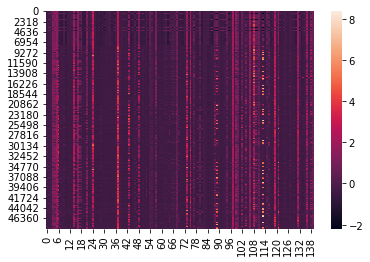

In [23]:
import seaborn as sns
sns.heatmap(test_pred)

In [24]:
def submit(test_pred,multi_path):
    submission = pd.read_csv(multi_path,index_col = 0)
    submission = submission["target"]
    print("data loaded")
    submission.iloc[:len(test_pred.ravel())] = test_pred.ravel()
    assert not submission.isna().any()
    # submission = submission.round(6) # reduce the size of the csv
    print("start -> submission.zip")
    submission.to_csv('submission.zip')
    print("submission.zip saved!")

In [25]:
%%time
submit(test_pred,multi_path = r"D:\python_project\MSCI\model_ensemble\submission_best.zip")

data loaded
start -> submission.zip
submission.zip saved!
CPU times: total: 57.8 s
Wall time: 3min 15s
